In [1]:
import os
if not os.environ.get("PREAMBLE_RUN", False): 
    %run -i 'preamble.py'

In [2]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED

In [3]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [4]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# PCA Analyisis

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(np.stack(df[EMBEDDING_MODEL]))

reduced_embeddings = pca.transform(np.stack(df[EMBEDDING_MODEL]))


In [6]:
pca.explained_variance_ratio_.sum()

np.float32(0.09815486)

PCA doesn't explain much variance 

KeyError: 'PSE/S&D'

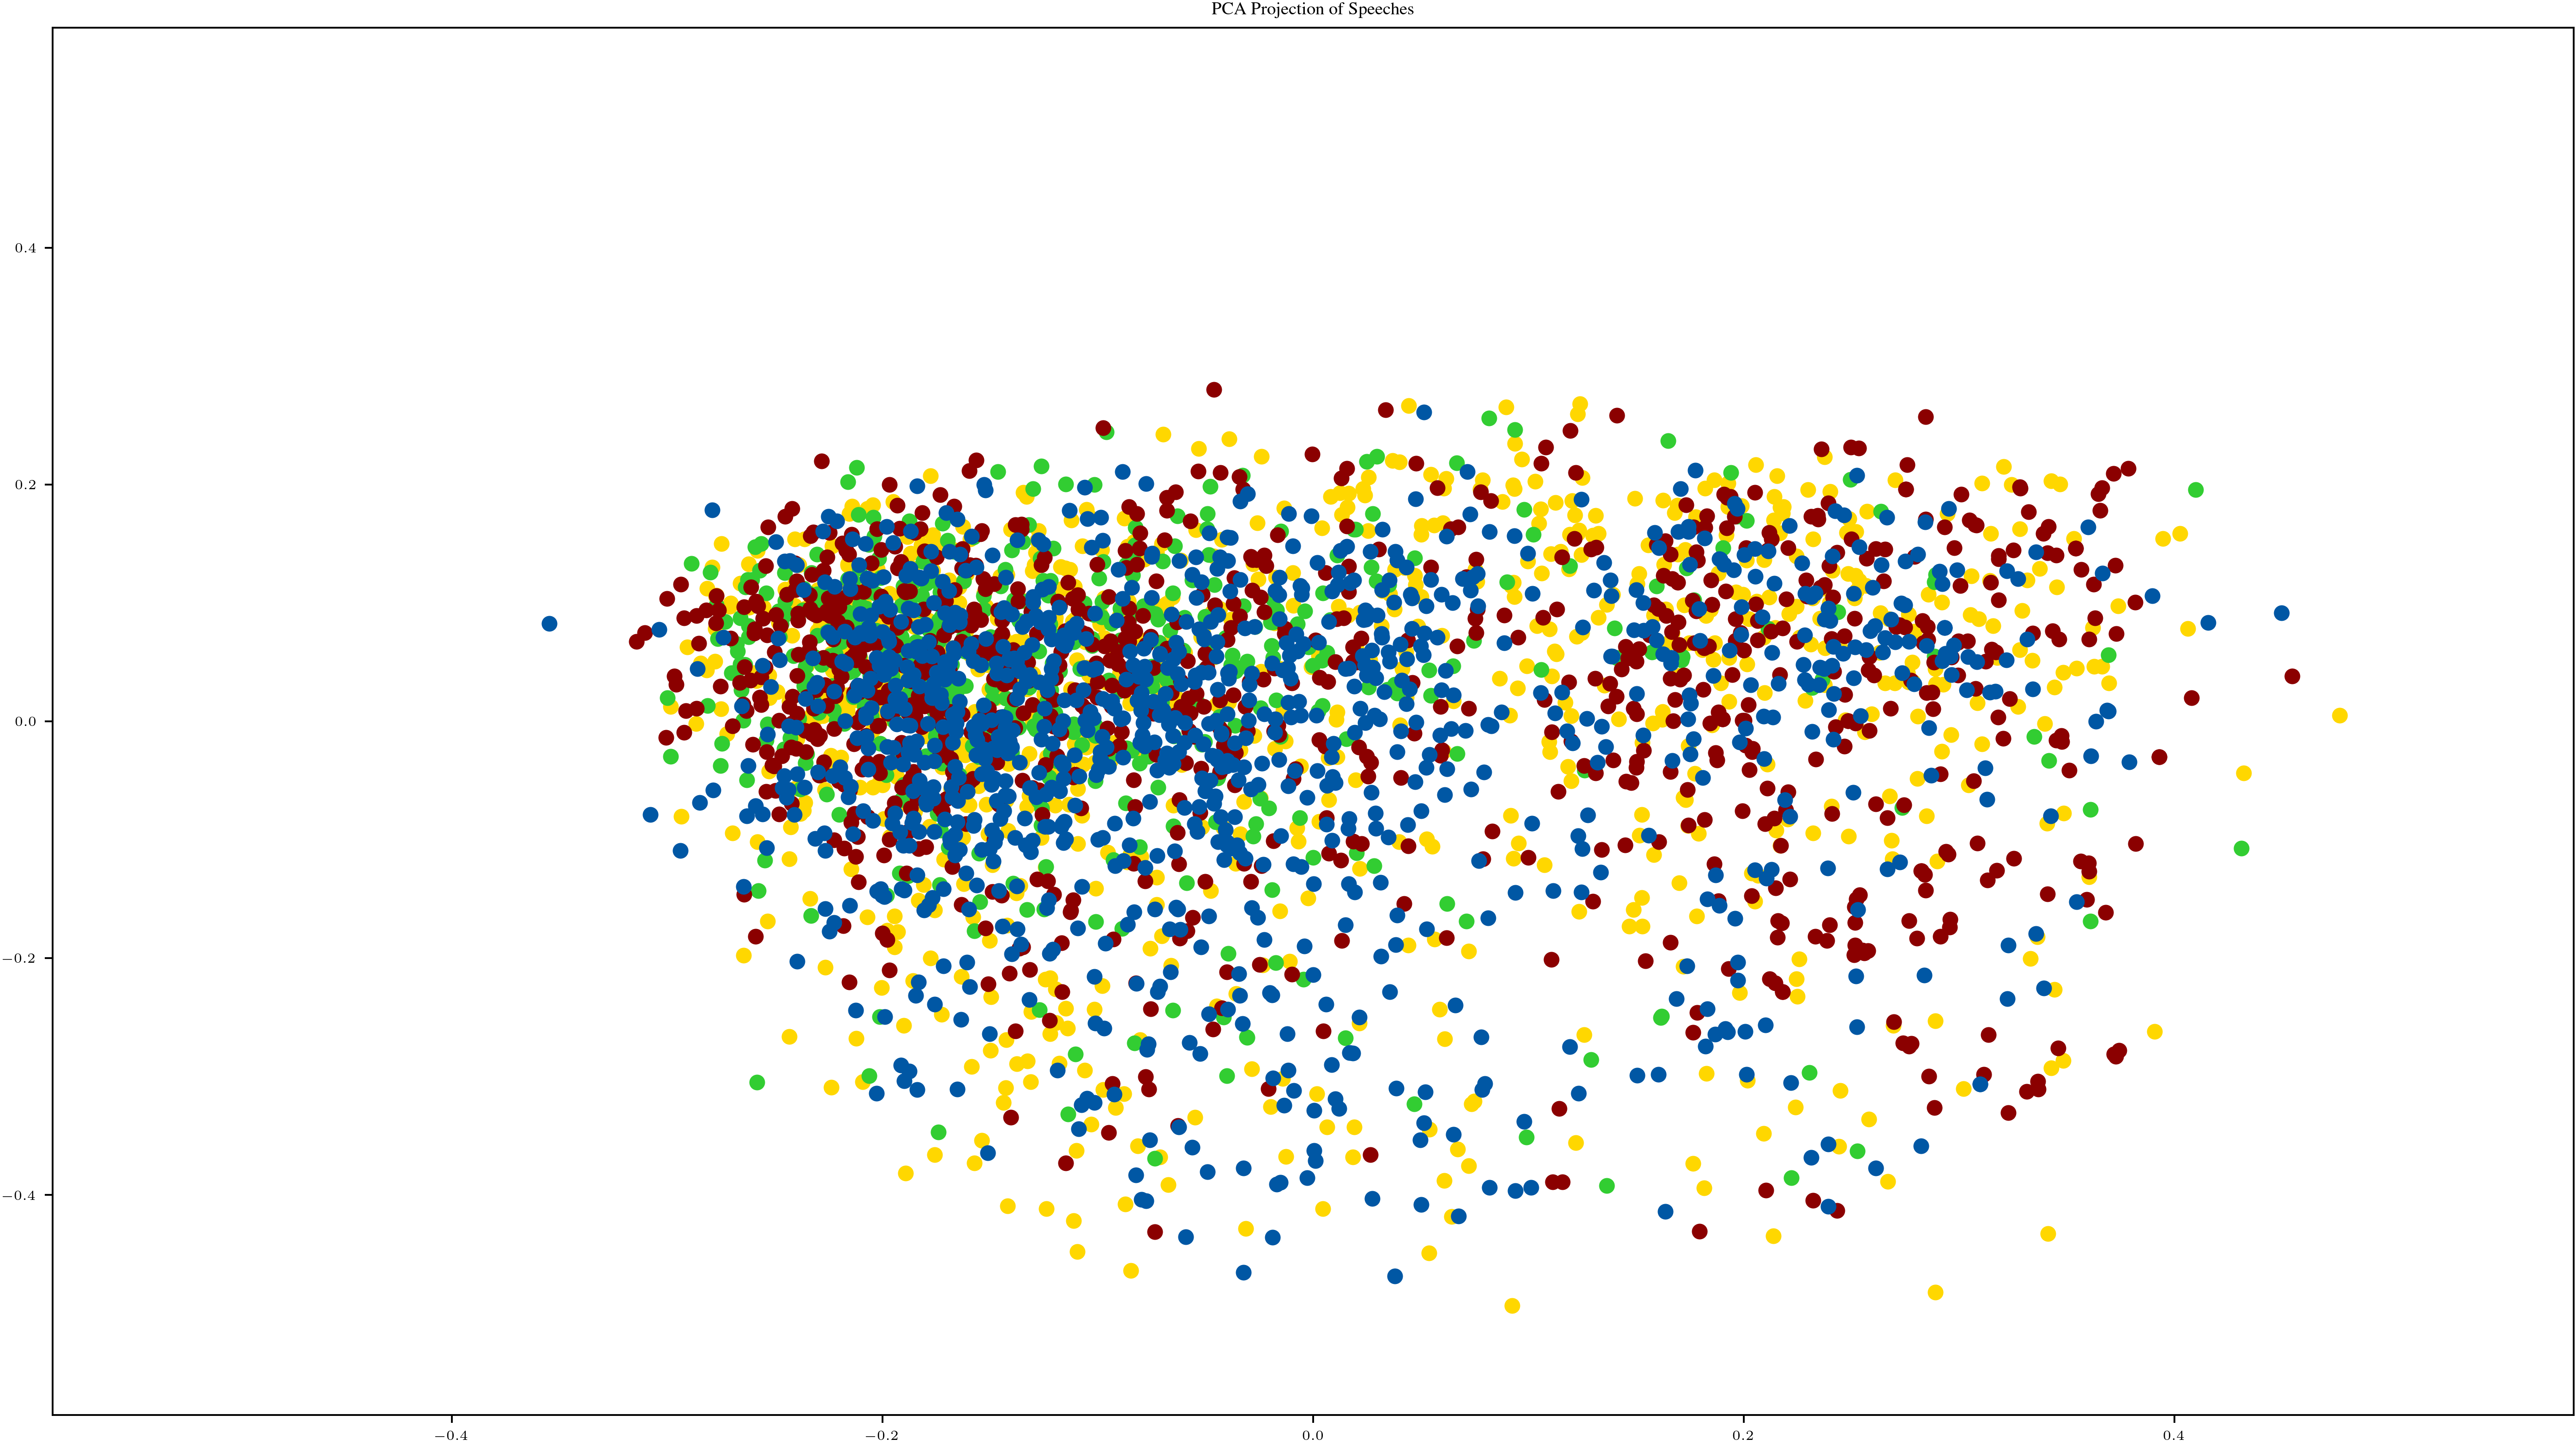

In [7]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
plt.title("PCA Projection of Speeches")

grt = np.abs(reduced_embeddings).max() * 1.1

ax.set_xlim(-grt, grt)
ax.set_ylim(-grt, grt)
scale = grt * 2


for party in df["party"].unique():
    party_mask = df["party"] == party
    party_embeddings = reduced_embeddings[party_mask]
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS['party'][party], label=party)

ax.legend()

No Apparent pattern visible. But we can try to interpret what this axis by looking at the words that have embeddings closest to the extreme points on the graphs

In [ ]:
# Transform vocab embeddings
vocab_embeddings = pca.transform(np.stack(vocab_df[EMBEDDING_MODEL]))

#  get axis 0 extreme examples
# normalized_vocab_emb = vocab_embeddings / np.linalg.norm(vocab_embeddings, ord=2, axis=1, keepdims=True)
sorted_indicies = vocab_embeddings[:, 0].argsort()

In [ ]:
vocab_df['word'].iloc[sorted_indicies[: 20]]

21007                        rede
18586                    speeches
5091                   presidenta
20642                 präsidentin
6557                   présidente
9952                   presidenza
7467                   presidente
18196                  presidents
6531                  presidencys
7478                    president
10635    παπαδημουλησαντιπρόεδρος
13648                presidencies
19507           presidentinoffice
6539                      geachte
17523                      señora
12761                    προεδρια
15556           presidentdictator
19840                      preach
15719                      speech
4525                    presenter
Name: word, dtype: object

In [ ]:
def closest_words_for_pc(k, model, vocab, probe_embs, top_n=20):
    reduced = model.transform(probe_embs)

    # reduced = reduced / np.linalg.vector_norm(reduced, ord=2, axis=1, keepdims=True)
    
    sorted_indices = np.argsort(reduced[:, k])
    pos_idx = sorted_indices[-top_n:]

    neg_idx = sorted_indices[:top_n]
    

    def map_indices_to_examples(index_list): 
        if isinstance(vocab, pd.DataFrame) or isinstance(vocab, pd.Series): 
            return [(vocab.iloc[i], reduced[:, k][i]) for i in index_list]
        else:
            return [(vocab[i], reduced[:, k][i]) for i in index_list]

    return map_indices_to_examples(neg_idx),  map_indices_to_examples(pos_idx)


In [ ]:
axis_labels_0 = closest_words_for_pc(0, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(1, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [ ]:
axis_labels_0

([('rede', np.float32(-0.1767091)),
  ('speeches', np.float32(-0.15144397)),
  ('presidenta', np.float32(-0.13677804)),
  ('präsidentin', np.float32(-0.13122377)),
  ('présidente', np.float32(-0.12173022)),
  ('presidenza', np.float32(-0.088277414)),
  ('presidente', np.float32(-0.08191717)),
  ('presidents', np.float32(-0.0800609)),
  ('presidencys', np.float32(-0.07933901)),
  ('president', np.float32(-0.073975116)),
  ('παπαδημουλησαντιπρόεδρος', np.float32(-0.066966265)),
  ('presidencies', np.float32(-0.06652516)),
  ('presidentinoffice', np.float32(-0.06130117)),
  ('geachte', np.float32(-0.05822827)),
  ('señora', np.float32(-0.05480832)),
  ('προεδρια', np.float32(-0.04370822)),
  ('presidentdictator', np.float32(-0.03337963)),
  ('preach', np.float32(-0.02582948)),
  ('speech', np.float32(-0.023496643)),
  ('presenter', np.float32(-0.02090995))],
 [('approved', np.float32(0.30116624)),
  ('outvoted', np.float32(0.30161268)),
  ('approvals', np.float32(0.3031217)),
  ('rapporte

In [ ]:
from IPython.display import display, HTML

def display_axis_semantics(axis_words: list[tuple[list[str]]]) -> None:
    data = []
    for axis, pairs in enumerate(axis_words):
        data.append({"Axis": axis, "Direction": "Neg", "Words": ", ".join([elem[0] for elem in pairs[0]])})
        data.append({"Axis": axis, "Direction": "Pos", "Words": ", ".join([elem[0] for elem in pairs[1]])})

    df = pd.DataFrame(data).set_index(["Axis", "Direction"])
    df['Words'] = df['Words'].str.wrap(100)
    display(HTML(df.to_html().replace("\\n","<br>")))

In [ ]:
display_axis_semantics([axis_labels_0, axis_labels_1])

In [ ]:
# normalized_embeddings = reduced_embeddings / np.linalg.vector_norm(reduced_embeddings, ord=2, axis=1, keepdims=True)

In [ ]:
# get extreme example speeches 
neg_0 = df['translatedText'].iloc[reduced_embeddings[:, 0].argmin().item()]
pos_0 = df['translatedText'].iloc[reduced_embeddings[:, 0].argmax().item()]
neg_1 = df['translatedText'].iloc[reduced_embeddings[:, 1].argmin().item()]
pos_1 = df['translatedText'].iloc[reduced_embeddings[:, 1].argmax().item()]

In [ ]:
import textwrap
print(textwrap.fill(pos_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[1]])))

I voted in favour of this report on the European Asylum Support Office
Closest Words:
approved, outvoted, approvals, rapporteurs, approves, project,
funding, approving, outvote, rapporteur, votar, voted, proposed,
votes, reporting, report, vote, voting, resolutionreport, reports


In [ ]:
print(textwrap.fill(neg_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[0]])))

Madam President, the Moria camp is indeed a tragedy, but it is a
tragedy that it even existed. It was burned by those who were inside,
because they wanted to accelerate their illegal entry into a continent
that cannot accommodate all other continents, no matter how many
people we have here representing, with that apparent moral
superiority, those who want to welcome everyone who wishes to come.
Because there is no room for them. And let's see if we show a little
respect for Europeans. Let's see if we respect the Greeks, who are
suffering because their habitat in Lesbos and so many other islands
has been destroyed. Why don't we address the root causes? Why don't we
look at Turkey, which has been manipulating these refugees, these
illegal immigrants who are gathering there, none of whom have the
right to asylum, who should have been deported and sent to their
countries of origin long ago, but who are being used by Turkey? Why
did everyone here condemn Turkey yesterday, and now they are i

In [ ]:
print(textwrap.fill(pos_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[1]])))

I voted in favor of the European Parliament resolution on migration
and refugees in Europe. According to UNHCR data, around 3 000 people
died or went missing in 2015 trying to reach Europe and that many of
those seeking asylum come from Syria, Afghanistan, Eritrea and Iraq.
The resolution welcomes the solidarity shown by many European
citizens, welcomes the Commission's initiatives on relocation and
resettlement by calling on it to amend the current Dublin Regulation,
urges the EU, the Member States and the international community to
strengthen their role in conflict resolution and, in particular, to
contribute to the search for sustainable political solutions in
conflict-affected regions, such as Iraq, Syria, Libya and the Middle
East and invites the Commission and the Vice-President of the
Commission/High Representative of the Union for Foreign Affairs and
Security Policy  to convene an international conference on the refugee
crisis with the aim of developing a common and global huma

In [ ]:
print(textwrap.fill(neg_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[0]])))

Following the terrorist attacks this year and last year, ten member
states of the Schengen area have reintroduced internal border
controls. Even if this is mostly only temporary, it still shows that
better external border controls are necessary to increase internal
security. It is precisely for this reason that I agreed to the
proposal with deep conviction. Frontex's powers need to be
significantly expanded. A European border and coast guard is to be
created to replace Frontex. This guard should be composed of the
national authorities responsible for border management, including the
coast guard. The concept of a European integrated management of
external borders is to be anchored in law for the first time. In
addition, the role of the agency in the area of returns, capacity
building and international cooperation with third countries is to be
strengthened.
Closest Words:
borderguards, bordersecurity, borderfree, border, frontières, borders,
borderof, boundary, confine, bordersand, secur

In [ ]:
def get_extreme_example_texts(df: pd.DataFrame, embeddings: np.array):
    neg_0 = df['translatedText'].iloc[embeddings[:, 0].argmin().item()]
    pos_0 = df['translatedText'].iloc[embeddings[:, 0].argmax().item()]
    neg_1 = df['translatedText'].iloc[embeddings[:, 1].argmin().item()]
    pos_1 = df['translatedText'].iloc[embeddings[:, 1].argmax().item()]

    return neg_0, pos_0, neg_1, pos_1

In [ ]:
(sum([label[0] in neg_1  for label in axis_labels_1[0]]), 
sum([label[0] in pos_1  for label in axis_labels_1[1]]), 
sum([label[0] in neg_0  for label in axis_labels_0[0]]),
sum([label[0] in pos_0  for label in axis_labels_0[1]]))

(2, 4, 0, 3)

terms themselves are mostly not present in our examples so we can assume that it isn't picking on rare words but on some underlying ideas

In [ ]:
def get_extreme_examples(df: pd.DataFrame, embeddings: np.array):
    return df.iloc[[embeddings[:, 0].argmin().item(),
                     embeddings[:, 0].argmax().item(),
                    embeddings[:, 1].argmin().item(),
                     embeddings[:, 1].argmax().item()]]

In [ ]:
examples = get_extreme_examples(df, reduced_embeddings)
reduced_examples = pca.transform(np.stack(examples[EMBEDDING_MODEL]))

(2,)
(2,)
(2,)
(2,)


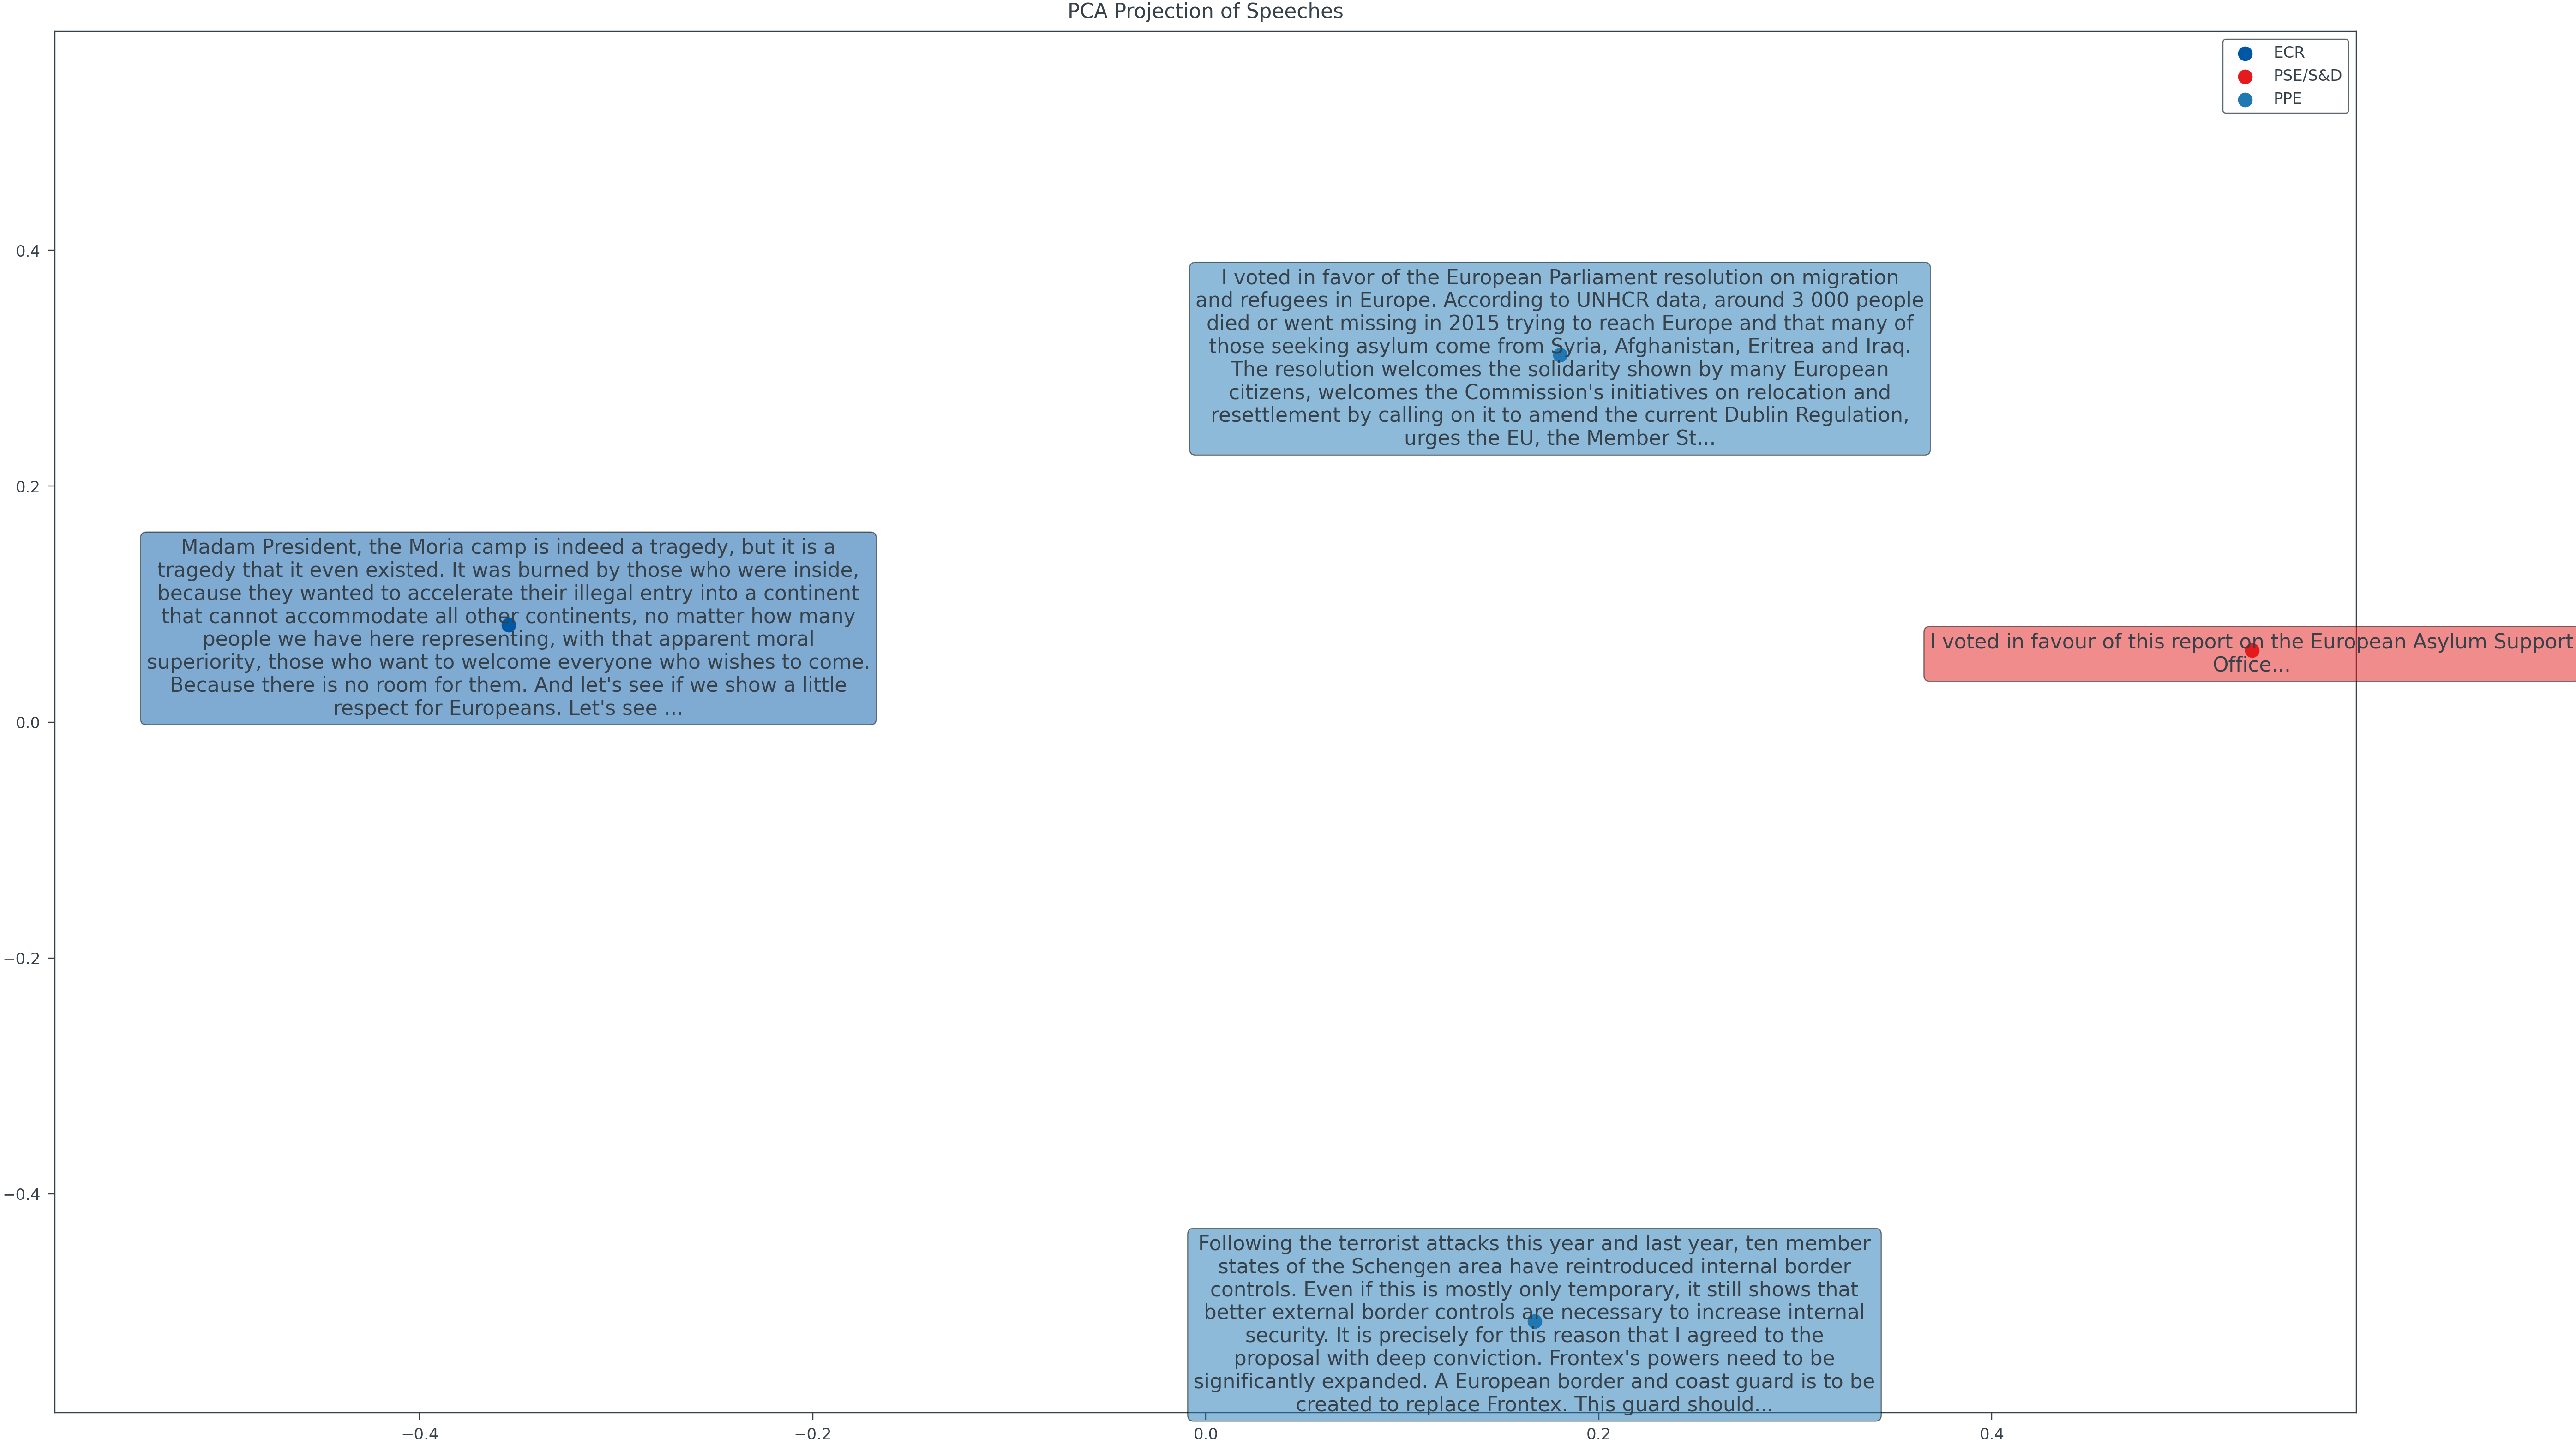

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
plt.title("PCA Projection of Speeches")

grt = np.abs(reduced_examples).max() * 1.1

ax.set_xlim(-grt, grt)
ax.set_ylim(-grt, grt)
scale = grt * 2



for party in examples["party"].unique():
    party_mask = examples["party"] == party
    party_embeddings = reduced_examples[party_mask]


    for idx, party_emb in enumerate(party_embeddings):
        print(party_emb.shape)

        props = dict(boxstyle='round', facecolor=COLOR_MAPS['party'][party], alpha=0.5)
        ax.text(party_emb[0], party_emb[1], s=textwrap.fill(examples[party_mask].iloc[idx]['translatedText'][:500] + "..."),
                verticalalignment='center_baseline', horizontalalignment="center",
                bbox=props)
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS['party'][party], label=party)

ax.legend()

In [ ]:
display_axis_semantics([axis_labels_0, axis_labels_1])

# Finding PCA Axis

Axis with highest variance might not be what we want we can try Principal Component Regression and identify PCs which have highest predictive power of our target variable. What we want to do is identify how parties differ and we can do that by finding hyperplane in the vector space which can identify and help us see this differences

## Party as target var

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder




X = np.stack(df[EMBEDDING_MODEL])

lb = LabelEncoder()
y = lb.fit_transform(df["party"])

print(f"#Classes {len(lb.classes_)}")


#Classes 8


In [ ]:
N_PCS = 100
pca = PCA(n_components=N_PCS)
X_pca =  pca.fit_transform(X)
pca.explained_variance_ratio_.sum()

np.float32(0.7025026)

In [ ]:
from tqdm import tqdm


results = np.zeros((N_PCS, N_PCS))

for pc_1 in tqdm(range(N_PCS)):
    for pc_2 in range(pc_1 + 1, N_PCS):
        pcr = LogisticRegression()
        pcr.fit(X_pca[:, [pc_1, pc_2]], y)
        results[pc_1, pc_2] = pcr.score(X_pca[:, [pc_1, pc_2]], y) 



100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [ ]:
pcs = np.unravel_index(results.argmax(), shape=(N_PCS, N_PCS))
print(f"PCA axis: {pcs}")

PCA axis: (np.int64(2), np.int64(5))


## Block as target var

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(df["block"])

print(f"#Classes {len(lb.classes_)}")

results = np.zeros((N_PCS, N_PCS))

for pc_1 in tqdm(range(N_PCS)):
    for pc_2 in range(pc_1 + 1, N_PCS):
        pcr = LogisticRegression()
        pcr.fit(X_pca[:, [pc_1, pc_2]], y)
        results[pc_1, pc_2] = pcr.score(X_pca[:, [pc_1, pc_2]], y) 

#Classes 6


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


In [ ]:
pcs = np.unravel_index(results.argmax(), shape=(N_PCS, N_PCS))
print(f"PCA axis: {pcs}")

PCA axis: (np.int64(2), np.int64(5))


In [ ]:
reduced_embeddings = X_pca[:, pcs]

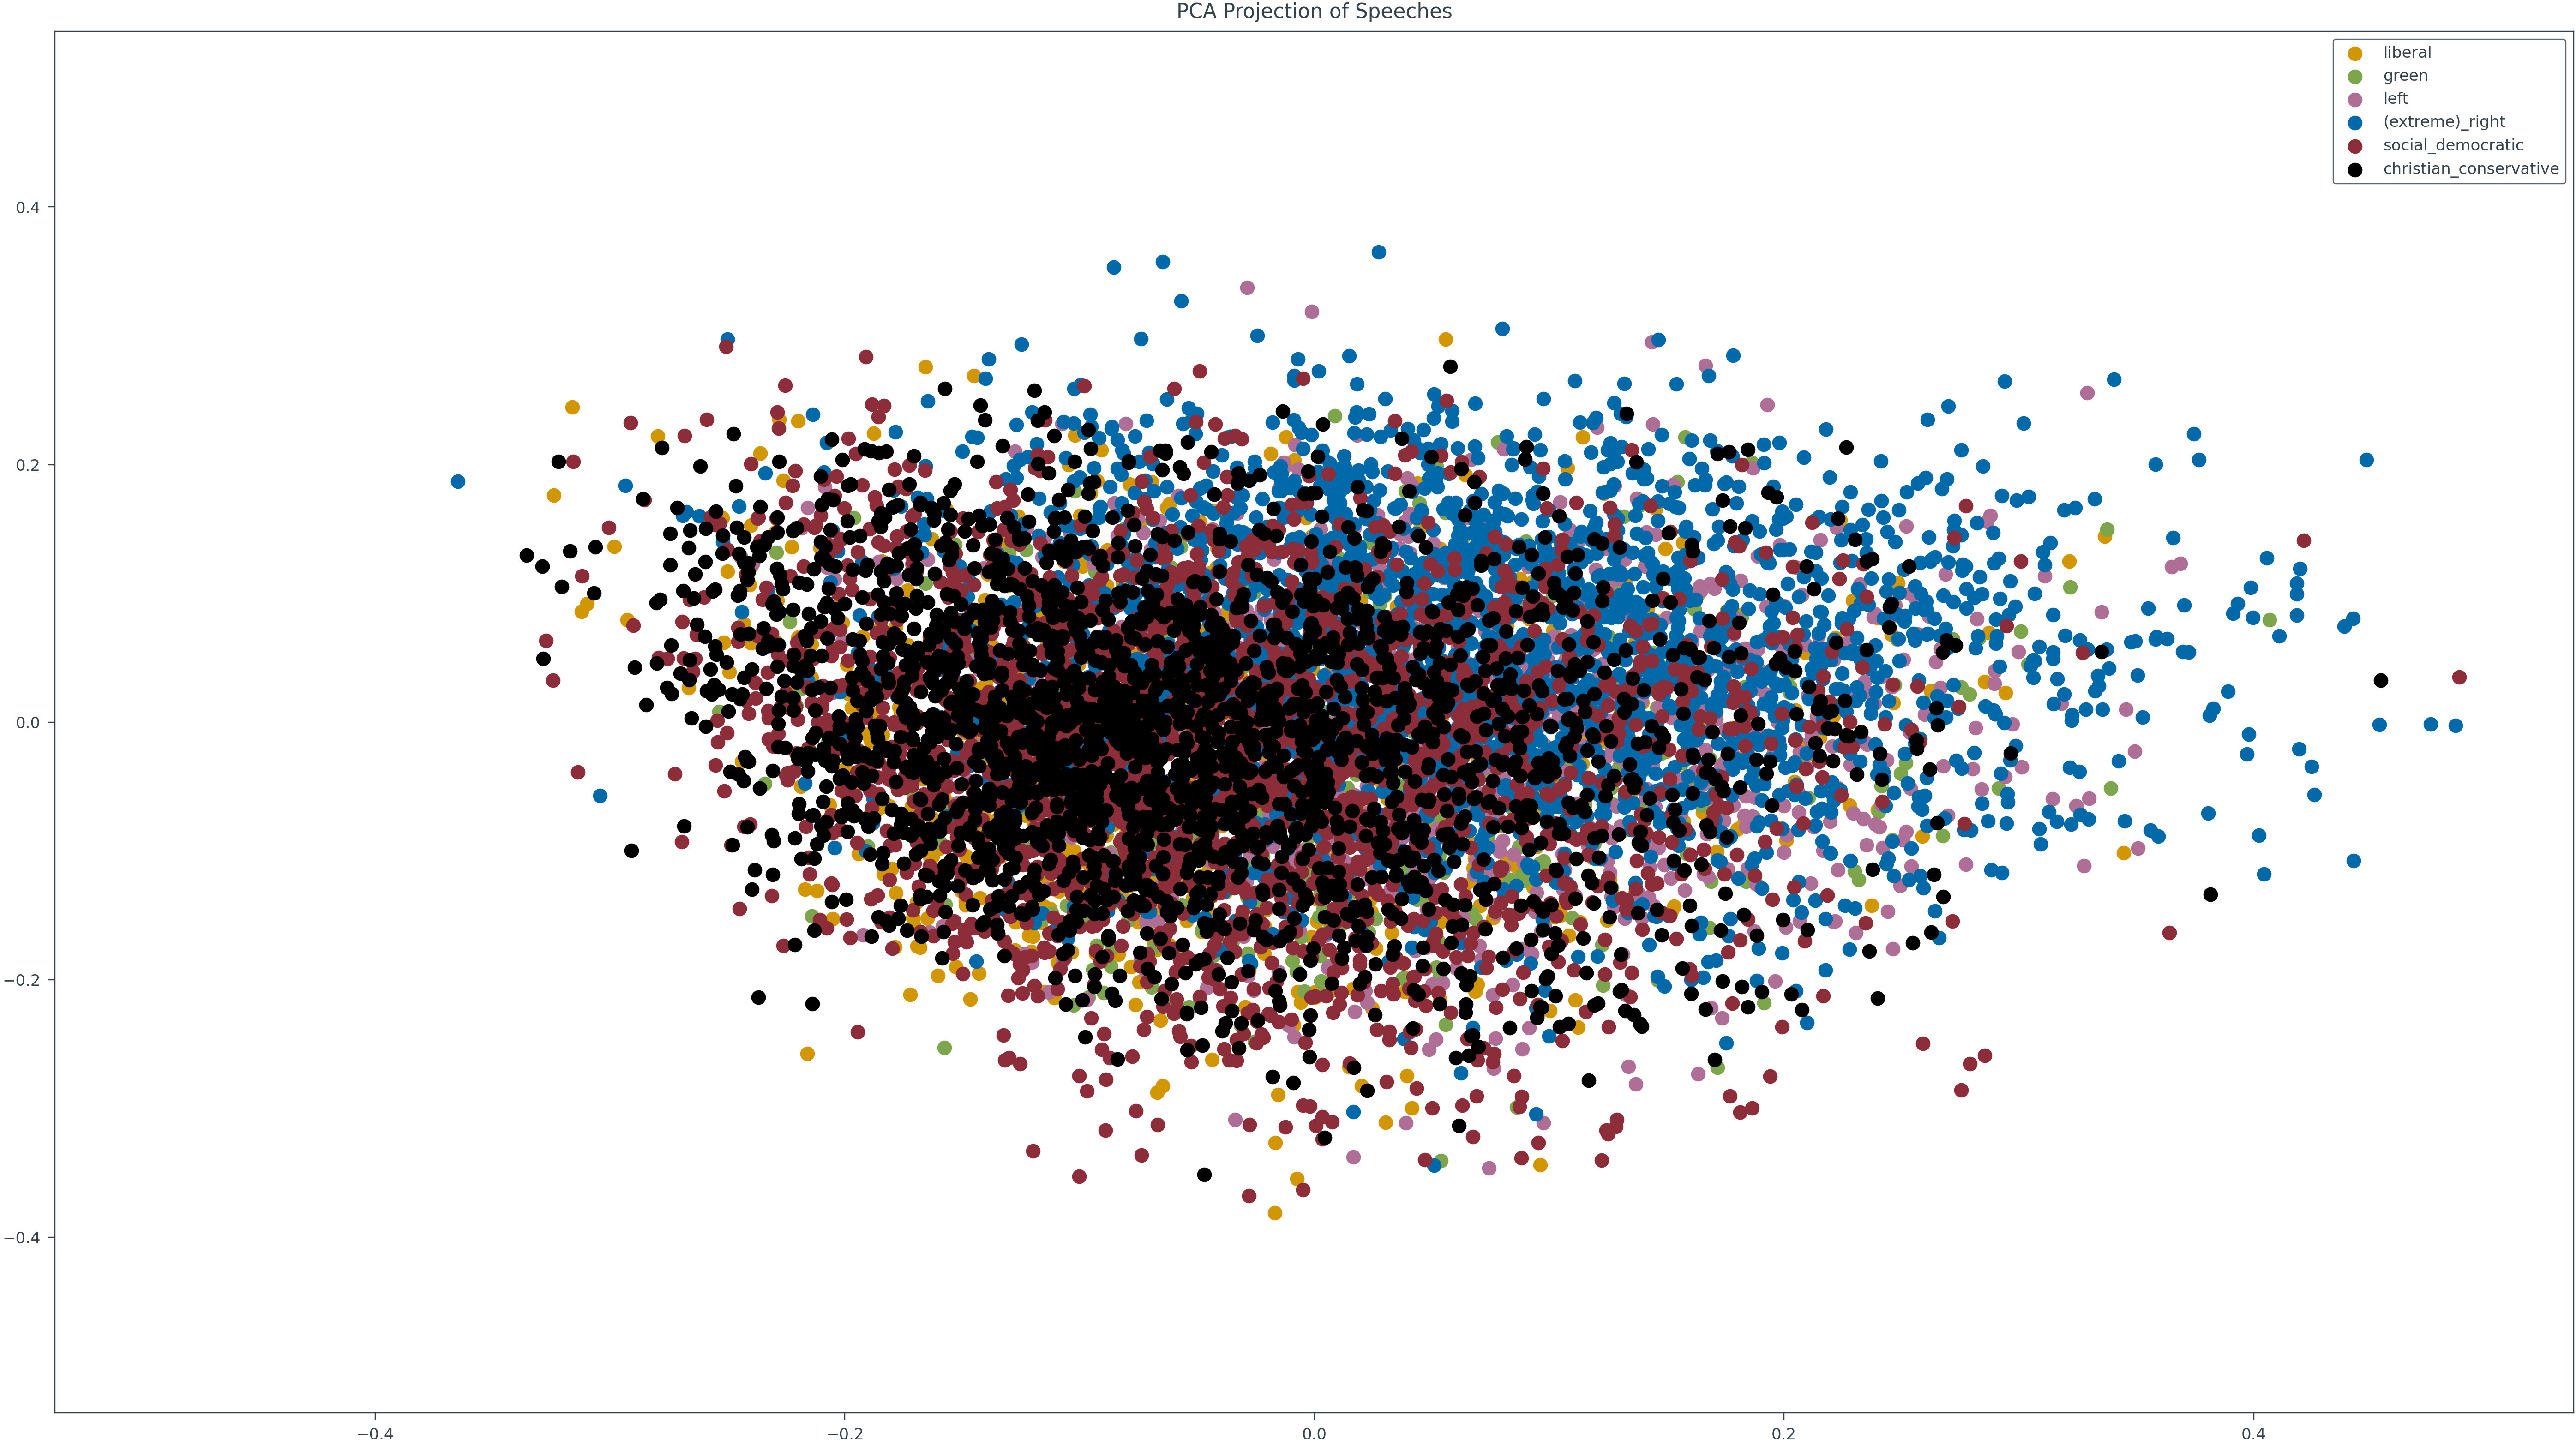

In [ ]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
plt.title("PCA Projection of Speeches")

grt = np.abs(reduced_embeddings).max() * 1.1

ax.set_xlim(-grt, grt)
ax.set_ylim(-grt, grt)
scale = grt * 2


for party in df["block"].unique():
    party_mask = df["block"] == party
    party_embeddings = reduced_embeddings[party_mask]
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=COLOR_MAPS['block'][party], label=party)

ax.legend()

In [ ]:
axis_labels_0 = closest_words_for_pc(2, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
axis_labels_1  = closest_words_for_pc(5, pca, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

In [ ]:
display_axis_semantics([axis_labels_0, axis_labels_1])

In [ ]:
neg_0, pos_0, neg_1, pos_1 = get_extreme_example_texts(df, reduced_embeddings )

In [ ]:
(sum([label[0] in neg_1  for label in axis_labels_1[0]]), 
sum([label[0] in pos_1  for label in axis_labels_1[1]]), 
sum([label[0] in neg_0  for label in axis_labels_0[0]]),
sum([label[0] in pos_0  for label in axis_labels_0[1]]))

(1, 3, 0, 0)

In [ ]:
print(textwrap.fill(pos_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[1]])))

It is one of the most disgusting abuses that exponents of the human
race are capable of. The fight against it is a noble and obligatory
cause for any sane person.
Closest Words:
castigate, disproven, slavery, despotic, dislike, despises, wronging,
repulsions, defamation, despise, subhuman, negatively, atrocious,
dislikes, dissent, negative, perverse, defamatory, repudiate,
denounces


In [ ]:
print(textwrap.fill(neg_0))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_0[0]])))

I welcome the proposal to adjust the EU budget for 2015 because the
European agencies Frontex, Europol and the European Asylum Support
Office play a key role in solving the refugee crisis and urgently need
additional funds. Also, the additional funds allocated under the
Asylum, Migration and Integration Fund and the Internal Security Fund
are extremely important and will help member countries. The first fund
will improve refugee reception capacity and the second will improve
border management. For Bulgaria, these funds are extremely important,
because we need additional help for our reception centers, as well as
for the construction of the EU's external border. Regarding the funds
provided for the regional fund for Syria and for the UN agencies, I
believe that the EU alone cannot cover the needs of these agencies,
nor should it alone be responsible for what is happening. The entire
international community must come together and provide funds, because
just as the Commission's plan for r

In [ ]:
print(textwrap.fill(pos_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[1]])))

Jordan faced an influx of 1.3 million Syrian refugees. The costs would
be $6.6 billion since 2011. It is therefore not absurd to help Jordan,
which largely bears its share of the burden regarding Syrian migrants.
However, the IMF and the EU are calling for structural adjustments.
The Jordanian economy is in serious financing difficulty, which
promises to destabilize it even more. I therefore abstain on this
text.
Closest Words:
financially, cost, costing, economies, counterproductive,
disastrously, economically, turkeygreece, turkishgreek, finances,
disastrous, economy, mismanaged, bankrupted, austerity, budget,
budgeted, costs, budgeting, economys


In [ ]:
print(textwrap.fill(neg_1))
print("=" * 100 )
print("Closest Words:")
print(textwrap.fill(", ".join([label[0] for label in axis_labels_1[0]])))

I want to thank the rapporteur for her work and I am pleased with the
approval of this report today, on International Working Women's Day.
Parliament therefore calls for special attention to women in asylum
policy. Reform of EU migration and asylum policies and procedures
needs to include measures to ensure the safety of women asylum
seekers, who often travel with young children and other dependent
family members. Asylum policies and procedures, including the
assessment of asylum claims, have to be gender-sensitive, while
gender-based violence – such as rape, sexual violence, genital
mutilation, forced marriages and domestic violence – must be
recognized as a valid reason to seek asylum in the EU. I have
supported this Resolution, which is as necessary as it is urgent.
Closest Words:
humanrightscompliant, humanrightsdriven, chairwoman, rightsrespecting,
dignities, präsidentin, congresswomen, rightsrights, womenrefugees,
womens, woman, dignity, women, inhumanity, rights, présidente,
gen

: 